<a href="https://colab.research.google.com/github/radarfundamentals/radar_course/blob/master/Nextrad_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NeXtRAD

Welcome to your NeXtRAD Notebook! This notebook will assist you in understanding radar data, signal processing and data visualisation.

## About NeXtRAD

NeXtRAD is a multistatic Pulse-Doppler radar that operates in the X and L bands. 

Radar Parameters:


![NeXtRAD Block Diagram](https://github.com/radarfundamentals/radar_course/blob/master/jupyter_images/Monostatic_node_2020.png?raw=true)

## Imports and Class Creation
This section imports several connects your Drive to the Colab and imports Python packages that we require to run our code. In particular, Scipy and Numpy allow us to run a few signal processing tricks, whilst Matplotlib allows us to plot any Data.

### Mount your Google Drive

Run the cell below. It will ask you to verify that you are allowing Google Colab access to your Google Drive. Click on the link that is generated, and  proceed to click accept/verify until you get to a long set of random numbers and letters. Copy this by clicking on the copy icon to the right of the text, and CNTRL+V (or right click paste) into the verification box on Google Colab. Hit enter once you have pasted.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# A bunch of imports to make things run
from os import listdir
from os.path import isfile, join
import re
import numpy as np
import matplotlib.pyplot as plt
import configparser
import tables
from scipy.io import loadmat
from scipy import signal
from sys import getsizeof
import matplotlib as mpl

%matplotlib inline
width = 20
height = 10
plt.rcParams['figure.figsize'] = [width, height]


### The Node Class

There are two Python classes below, with the Node class being the most important to you.

The class takes in a NeXtRAD.ini header file and processor config file, which relates to the current experiment. Knowing how any of this works is unimportant for this course. However, we will use a few of the classes built-in methods to shape our data into usable data, find radar parameters, and plot the data in a presentable way.

We'll demonstrate how to create a radar object with your data, and how to use a few of the function to process the data.

Note: the plots in Colab are not interactable unfortunatley, due to Colab not yet fully supporting this feature.  

In [0]:
# About:
# A header class that reads a NeXtRAD.ini file and sorts the header details into a header object
class NextHeader:
    def __init__(self, setup_file, headerfile=None):

        self.proc_config_ini = setup_file
        self.proc_config = configparser.ConfigParser(comment_prefixes='/', allow_no_value=True)
        self.proc_config.optionxform = lambda option: option  # preserve case for letters
        self.proc_config.read(self.proc_config_ini)
        self.synth_dir = self.proc_config['Directories']['reference_synths']
        self.nodes_dir = self.proc_config['Directories']['experiment_folder']

        if headerfile == None:
            self.config_ini = self.nodes_dir+'/NeXtRAD.ini'
        else:
            self.config_ini = headerfile

        self.specific_channel = int(self.proc_config['DataSettings']['specify_channels'])
        self.auto_channel = int(self.proc_config['DataTweaks']['auto_channel'])
        self.auto_blanking = int(self.proc_config['DataTweaks']['auto_blanking'])
        #self.reference_file = synth_dir + '/RefPulse_' + params['bands'][specific_channel] + 'band_' + str(int(params['pulse_width'][specific_channel])) + 'us.mat'
        self.pulse_of_interest = int(self.proc_config['DataSettings']['pulse_of_interest'])
        self.range_bin_of_interest = int(self.proc_config['DataSettings']['bin_of_interest'])
        self.range_blank = int(self.proc_config['DataSettings']['blanking_range'])
        self.spec_low = int(self.proc_config['Spectrogram']['spectrogram_primary_bin'])-int(self.proc_config['Spectrogram']['spectrogram_side_size'])
        self.spec_high = int(self.proc_config['Spectrogram']['spectrogram_primary_bin'])+int(self.proc_config['Spectrogram']['spectrogram_side_size'])
        self.config = configparser.ConfigParser(comment_prefixes='/', allow_no_value=True)
        self.config.optionxform = lambda option: option  # preserve case for letters
        print('Processor config values updated.')
        print('NeXtRAD Header: ' + self.config_ini)
        self.config.read(self.config_ini)
        # Initiate config parameters
        self.range_samples = int(self.config['PulseParameters']['SAMPLES_PER_PRI'])
        self.experiment_name = self.config['Notes']['EXPERIMENT_NAME']
        self.target_description = self.config['Notes']['EXPERIMENT_NOTES']
        self.start_time_str = self.config['Timing']['YEAR']+'_'+ self.config['Timing']['MONTH']+'_' + self.config['Timing']['DAY']+'_' + self.config['Timing']['HOUR']+'_' + self.config['Timing']['MINUTE']+'_' + self.config['Timing']['SECOND']

        try:
            self.nodes = [int(self.config['GeometrySettings']['NODE0_INCLUDE']),int(self.config['GeometrySettings']['NODE1_INCLUDE']),int(self.config['GeometrySettings']['NODE2_INCLUDE'])]
        except:
            print('Using Old Header. All Nodes Included')
            self.nodes = [1,1,1]

        self.node_latlonalt = [self.config['GeometrySettings']['NODE0_LOCATION_LAT']+','+self.config['GeometrySettings']['NODE0_LOCATION_LON']+','+self.config['GeometrySettings']['NODE0_LOCATION_HT'], self.config['GeometrySettings']['NODE1_LOCATION_LAT']+','+self.config['GeometrySettings']['NODE1_LOCATION_LON']+','+self.config['GeometrySettings']['NODE1_LOCATION_HT'], self.config['GeometrySettings']['NODE2_LOCATION_LAT']+','+self.config['GeometrySettings']['NODE2_LOCATION_LON']+','+self.config['GeometrySettings']['NODE2_LOCATION_HT']]
        self.target_latlon = self.config['TargetSettings']['TGT_LOCATION_LAT']+','+self.config['TargetSettings']['TGT_LOCATION_LON']
        self.num_pri = int(self.config['PulseParameters']['NUM_PRIS'])
        pulses_str = self.config['PulseParameters']['PULSES']
        self.pri = []
        self.bands = []
        self.pols = []
        self.pulse_width = []
        self.pulses = []
        self.carrier_f = []
        self.pulses_arr = pulses_str.split('|')

        for pulse in range(len(self.pulses_arr)):
            self.pulses_arr[pulse]=self.pulses_arr[pulse].replace('\"','')
            self.pulses.append(self.pulses_arr[pulse].split(','))
            self.pri.append(float(self.pulses[pulse][1]))
            self.pols.append(int(self.pulses[pulse][2]))
            self.carrier_f.append(float(self.pulses[pulse][3].replace('\"','')))
            if float(self.pulses[pulse][3]) > 4000:
                self.bands.append('X')
            else:
                self.bands.append('L')

            self.pulse_width.append(float(self.pulses[pulse][0].replace('\"','')))

            self.num_pulse_types = len(self.bands)
            self.radar_prf = (1e6/self.pri[0])
            self.prf_eff = self.radar_prf/self.num_pulse_types

            self.PC_matrix = 0

            self.pulses_processed = int(self.proc_config['DataSettings']['num_samples_to_process'])
            if self.pulses_processed > self.num_pri:
                self.pulses_processed = self.num_pri
            if self.pulses_processed == 0:
                self.pulses_processed = self.num_pri

    def print_radar_details(self):
        print('Name of Experiment: ' + self.experiment_name)
        print('Experiment DateTime: ' + self.start_time_str)
        print('Radar PRF: ' + str(self.radar_prf))
        print('Radar PRI: ' + str(self.pri[0]))
        print('Total Number of Pulses: ' + str(self.num_pri))
        print('Range Samples: ' + str(self.range_samples))
        print('Number of Pulse Types: ' + str(self.num_pulse_types))
        print('Effective Pulse PRF: ' + str(self.prf_eff))
        print('Bands: ' + str(self.bands))
        print('Carrier Frequencies: ' + str(self.carrier_f))
        print('Pulse Widths: ' + str(self.pulse_width))
        print('Polarisations: ' + str(self.pols))


# About:
# A class for each node that the user requires. Inherits the header used for the general radar parameters.
# Takes in the header object and node specific number (0,1 or 3). There is node active section in the header which
# tells the user which nodes were actually used in the experiment - this may assist in autoprocessing multiple nodes.
class Node(NextHeader):
    def __init__(self, node_num, setup_file, headerfile=None, Lchan_file=None, XVchan_file=None, XHchan_file=None):
        super().__init__(setup_file, headerfile)
        self.node_num = node_num
        self.raw_IQ = 0
        self.Lchan_file = Lchan_file
        self.XVchan_file = XVchan_file
        self.XHchan_file = XHchan_file
        if self.auto_channel == 1:
            mypath = self.nodes_dir
            onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
            for word in onlyfiles:
                if self.Lchan_file == None:
                    if re.search('.adc0.dat',word):
                        self.Lchan_file = self.nodes_dir + word
                if self.XVchan_file == None:
                    if re.search('.adc1.dat',word):
                        self.XVchan_file = self.nodes_dir + word
                if self.XHchan_file == None:
                    if re.search('.adc2.dat',word):
                        self.XHchan_file = self.nodes_dir + word


    def format_data(self, data_file, number_pulses=None, blanking=None):
        if number_pulses == None:
            number_pulses = self.pulses_processed

        print('Creating Raw IQ Matrix for ' + str(number_pulses) + ' pulses ...')

        data = np.fromfile(data_file, dtype=np.int16, count=2*number_pulses*self.range_samples)
        raw_IQ = data[0::2] + 1j*data[1::2]

        raw_IQ = np.reshape(raw_IQ,(number_pulses,self.range_samples))
        if blanking == None:
          if self.range_blank > 0 and self.auto_blanking == 0:
            for pulse in raw_IQ:
                pulse[0:self.range_blank] = 0
        else:
          for pulse in raw_IQ:
            pulse[0:blanking] = 0

        print('Complete.')

        return raw_IQ

    def deinterleave(self, data_matrix, num_pulse_types=None, total_pulses=None, num_range_bins=None):
        if num_pulse_types == None:
            num_pulse_types = self.num_pulse_types
        if total_pulses == None:
            total_pulses = self.pulses_processed
        if num_range_bins == None:
            num_range_bins = self.range_samples

        data_channels = np.zeros((num_pulse_types,total_pulses//num_pulse_types,num_range_bins),dtype=complex)
        for i in (range(num_pulse_types)):
            data_channels[i] = data_matrix[i::num_pulse_types]

        return data_channels

    def match_filter(self, raw_IQ, specific_channel=None, window=None):

        if specific_channel == None:
            specific_channel = self.specific_channel

        self.reference_file = self.synth_dir + '/RefPulse_' + str(self.bands[specific_channel]) + 'band_' + str(int(self.pulse_width[specific_channel])) + 'us.mat'
        print('Reference File: ' + self.reference_file)
        mat_synth_ref = loadmat(self.reference_file)
        reference = mat_synth_ref['Ref_sig']
        print('Running Pulse Compression ...')
        fft_matrix = np.fft.fft(raw_IQ)
        reference = np.pad(np.transpose(reference)[0], (0,self.range_samples-len(reference)))
        fft_ref = np.fft.fft(reference)
        fast_convolve = fft_matrix*np.conjugate(fft_ref)
        pulse_compressed_matrix = np.fft.ifft(fast_convolve)
        print('Complete.')

        return pulse_compressed_matrix, reference


    def doppler_spectrum(self, pulse_matrix, limits=None, range_bin=None, num_bins_avg=None, prf=None, npseg=None, novp=None, window=None, n_fft=None):
        if range_bin == None:
            range_bin = self.range_bin_of_interest
        if prf == None:
            prf = self.prf_eff

        if num_bins_avg == None:
            x = pulse_matrix[:, range_bin]
        else:
            x = np.sum(pulse_matrix[:,(range_bin-num_bins_avg[0]):(range_bin+num_bins_avg[1])],axis=1)

        if limits != None:
            x = x[limits[0]:limits[1]]

        f, t, Sxx = signal.spectrogram(x, prf, nperseg=npseg, noverlap=novp, nfft=n_fft, return_onesided=False)

        # todo windowing
        return f, t, Sxx

    def plot_rti(self, pulse_matrix, range_limits=None, pulse_limits=None, cmap_rti='jet', logplot=False, normalise=False):

        fig = plt.figure()
        if range_limits == None:
          range_limits = [0, self.range_samples]

        if logplot == False:
          x = np.transpose(abs(pulse_matrix))
        else:
          x = np.transpose(10*np.log10(abs(pulse_matrix)))

        x = x[range_limits[0]:range_limits[1]]

        if pulse_limits == None:
            pulse_limits = [0,np.shape(x)[1]]
        else:
            x = x[:,pulse_limits[0]:pulse_limits[1]]

        if normalise == True:
            x = x/np.max(x)

        plt.imshow(x, extent=[pulse_limits[0],pulse_limits[1],range_limits[0],range_limits[1]], aspect='auto', cmap=cmap_rti, origin='lower')
        return fig

    def plot_pulse_mag(self,matrix,pulse=None,real_amp=None):
        if pulse == None:
            pulse = self.pulse_of_interest
        fig = plt.figure()
        plt.plot(np.real(matrix[pulse]))

        return fig

    def plot_raw(self,raw_to_plot,name):
        axis = plt.subplot()
        
        axis.set_title(name)
        axis.set_xlabel('Number of Samples')
        axis.set_ylabel('Amplitude')

        axis.plot(raw_to_plot)
        return axis


    def plot_spectrogram(self, f, t, Sxx, range_bin=None, f_limits=None, cmap_spec='jet', logplot=False):
        if range_bin == None:
            range_bin = self.range_bin_of_interest
        fig = plt.figure()

        if logplot == True:
            Sxx = 10*np.log10(Sxx)

        plt.pcolormesh(t, np.fft.fftshift(f), np.fft.fftshift(Sxx, axes=0),cmap=cmap_spec)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')

        return fig

## Your Code Here

In this Section you will develop your own code to process NeXtRAD data, using functions built into the Node class. The above may look overwhelming if you have not been exposed to much Python, but we will use simple methods to manipulate and plot the data.

### Import Data

The first step will require giving Colab access to a folder in your Google Drive, from which we will be able to import data to process.


In [4]:
%cd /gdrive/My\ Drive/Colab\ Notebooks/test_2
%cat ../proc_config.ini

/gdrive/My Drive/Colab Notebooks/test_2
[Directories]
experiment_folder = ./
reference_synths = ../Data/Ref_Synth
file = None

[DataTweaks]
auto_blanking = 0
auto_channel = 1

[DataSettings]
num_samples_to_process = 10000
blanking_range = 500
specify_channels = 0
bin_of_interest = 743
pulse_of_interest = 100

[Spectrogram]
spectrogram_primary_bin = 860
spectrogram_side_size = 20


In [5]:
processor_setup_file = '../proc_config.ini'
radar_ini = 'NeXtRAD.ini'
radar = Node(0,processor_setup_file,radar_ini)

radar.print_radar_details()


Processor config values updated.
NeXtRAD Header: NeXtRAD.ini
Name of Experiment: 2 Drones, Quad and Hex
Experiment DateTime: 2019_12_11_10_04_32
Radar PRF: 999.000999000999
Radar PRI: 1001.0
Total Number of Pulses: 90000
Range Samples: 2048
Number of Pulse Types: 1
Effective Pulse PRF: 999.000999000999
Bands: ['L']
Carrier Frequencies: [1300.0]
Pulse Widths: [5.0]
Polarisations: [3]


In [6]:
IQ_matrix = radar.format_data(radar.Lchan_file, number_pulses=40000, blanking=500)

Creating Raw IQ Matrix for 40000 pulses ...
Complete.


In [7]:
PC_matrix, reference = radar.match_filter(IQ_matrix)

Reference File: ../Data/Ref_Synth/RefPulse_Lband_5us.mat
Running Pulse Compression ...
Complete.


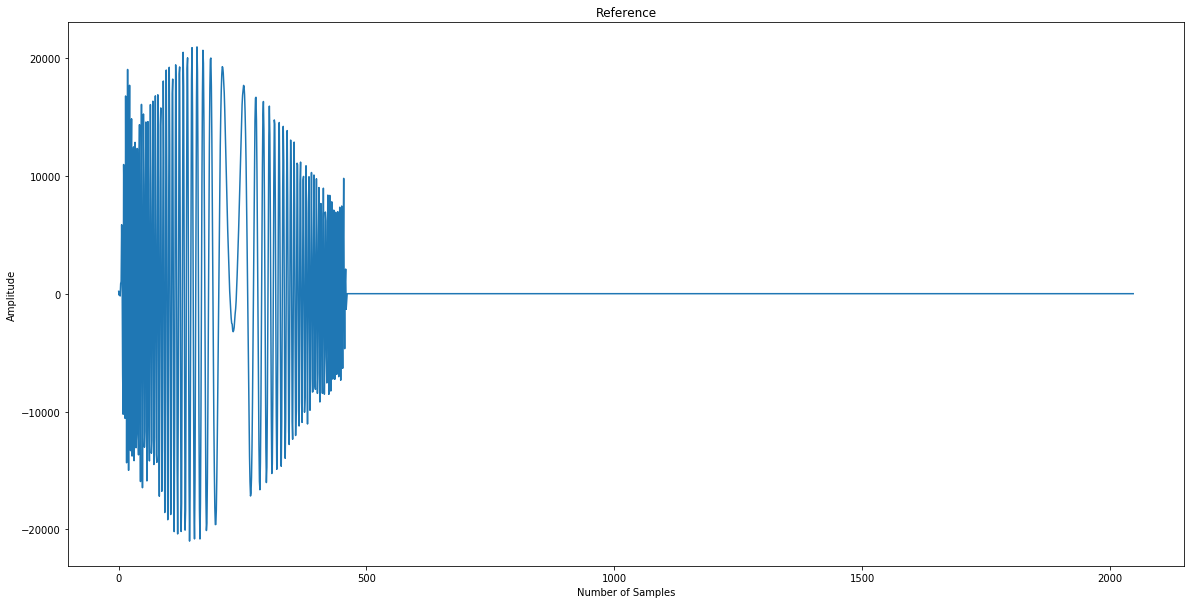

In [8]:
radar.plot_raw(np.real(reference),'Reference')

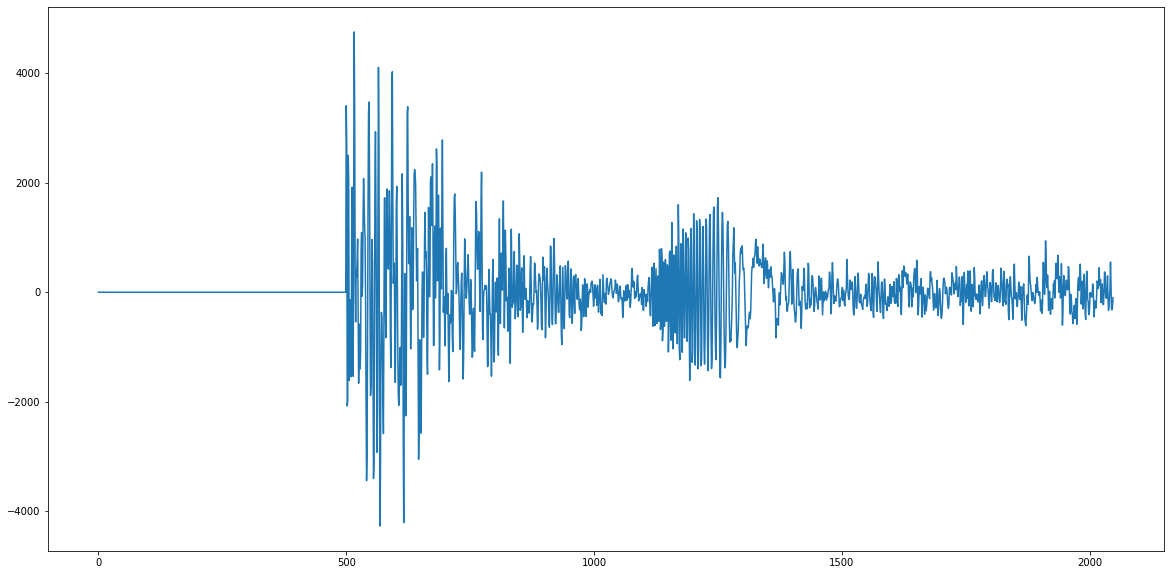

In [9]:
fig1 = radar.plot_pulse_mag(IQ_matrix)


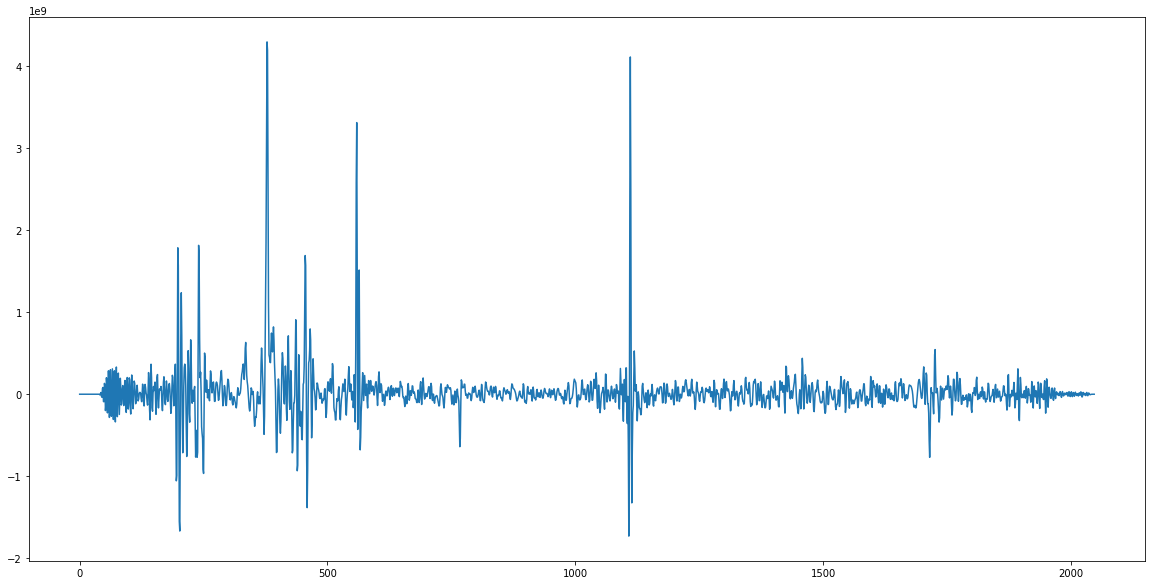

In [10]:
fig2 = radar.plot_pulse_mag(PC_matrix)


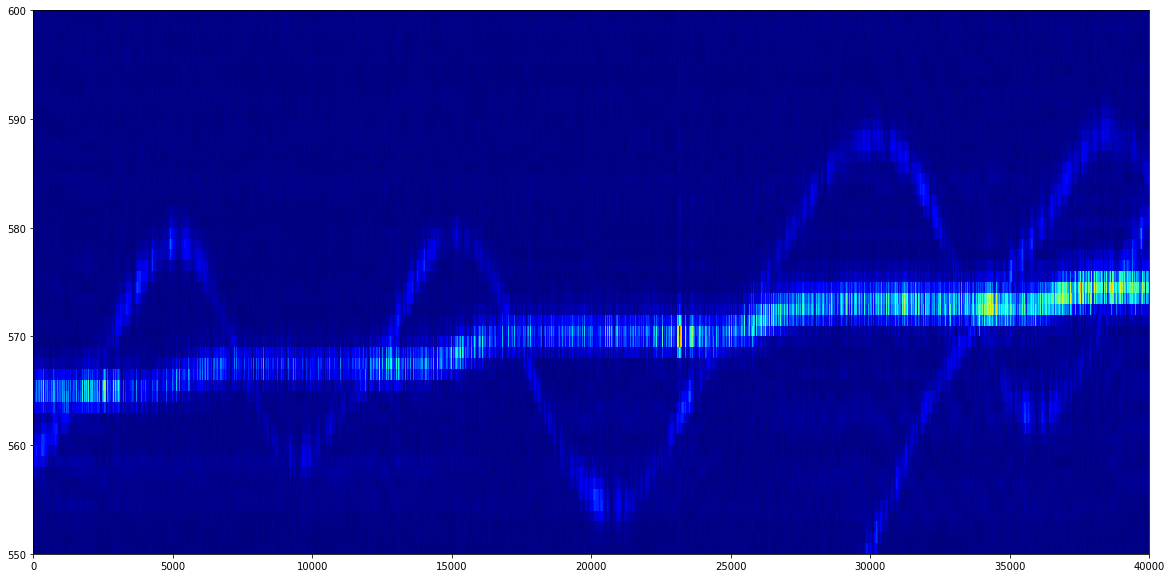

In [11]:
fig3 = radar.plot_rti(PC_matrix, range_limits=[550,600])

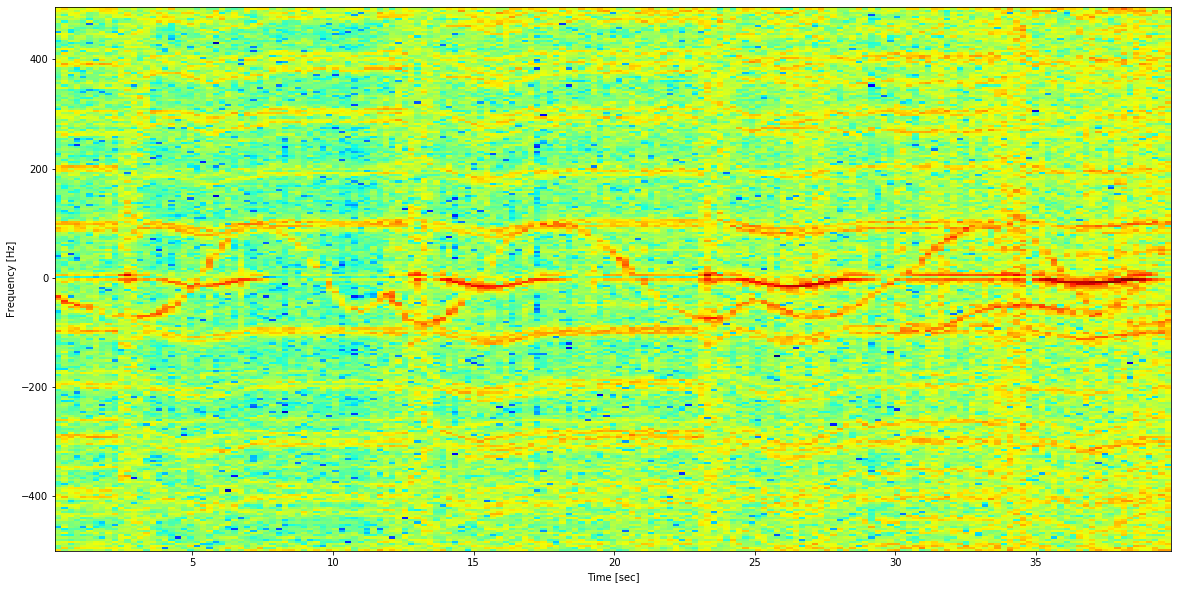

In [12]:
f, t, Sxx = radar.doppler_spectrum(PC_matrix,range_bin=570,num_bins_avg=[20,20])
fig4 = radar.plot_spectrogram(f,t,Sxx,logplot=1, cmap_spec='jet')